# Rice Classification

<a class="anchor" id="About_Data"></a>
# <p style="padding:10px;background-color:#d5eae9;margin:0;color:#c27849;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">About Data</p> 

<div style="background-color:#d5eae9; padding:20px; font-size:15px">

**Content:** 

Rice, which is among the most widely produced grain products worldwide, has many genetic varieties. These varieties are separated from each other due to some of their features. These are usually features such as texture, shape, and color. With these features that distinguish rice varieties, it is possible to classify and evaluate the quality of seeds. In this study, Arborio, Basmati, Ipsala, Jasmine and Karacadag, which are five different varieties of rice often grown in Turkey, were used. A total of 75,000 grain images, 15,000 from each of these varieties, are included in the dataset.



In [4]:
# import libraries 
import os
import pathlib
import numpy as np
import splitfolders
import itertools
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

In [4]:
# dataset path
data_dir = 'E:\Deep Learning\IMT\CNN\Rice_Image_Dataset'
data_dir = pathlib.Path(data_path)

In [5]:
# create folder for train, validation and test set
splitfolders.ratio(input=data_path, output='rice_imgs', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [13:29, 92.63 files/s] 


In [7]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((250,250)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ]
)

# import and load train, validation and test set
BATCH_SIZE = 32

train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
print("Tarin", train_set, "\n")
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
print("Validation", val_set, "\n")
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.ImageFolder(data_dir.joinpath("test"), transform=transform)
print("Test", test_set, "\n")
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

class_names = ("Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag")

Tarin Dataset ImageFolder
    Number of datapoints: 52500
    Root location: /kaggle/working/rice_imgs/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

Validation Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/rice_imgs/val
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

Test Dataset ImageFolder
    Number of datapoints: 1125

In [8]:
# print shape of dataset 
for key, value in {'Train': train_loader, "Validation": val_loader, 'Test': test_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Train:
Shape of X [N, C, H, W]: torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64

Validation:
Shape of X [N, C, H, W]: torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64

Test:
Shape of X [N, C, H, W]: torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64



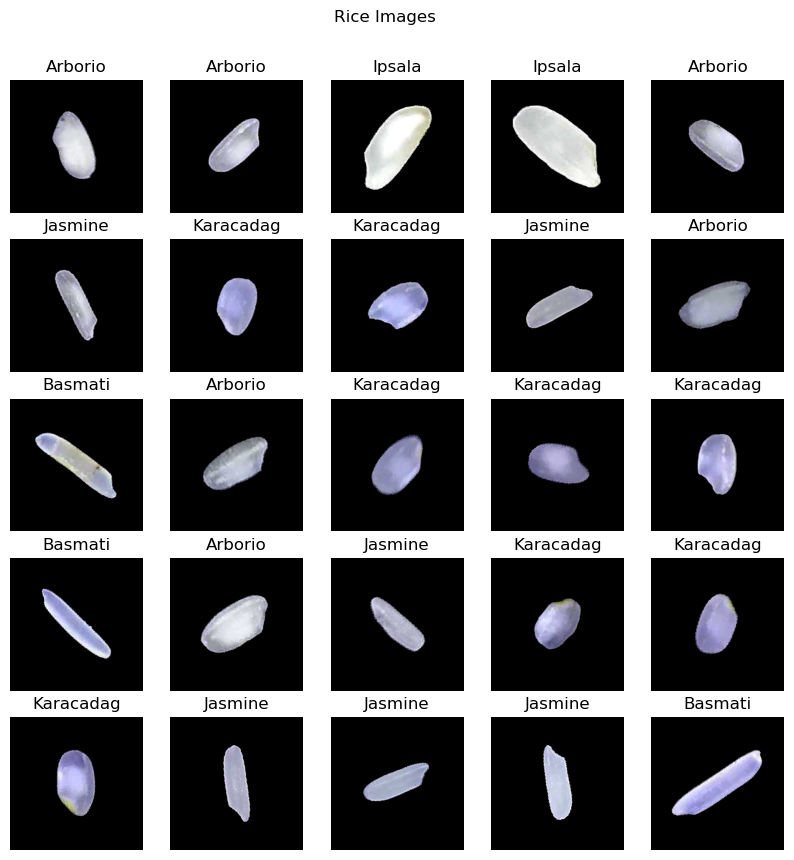

In [9]:
# visualizing 
labels_map = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Rice Images', y=0.95)
plt.show()

<a class="anchor" id="About_Data"></a>
# <p style="padding:10px;background-color:#d5eae9;margin:0;color:#c27849;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model 1</p> 

In [10]:
# Define first CNN Model: 1 conv layer | 1 pool layer | 2 full-connected layer | RelU activation
class Model1(nn.Module):
    def __init__(self, dim_output):
        super().__init__()

        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=32*124*124, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=dim_output),
        )

    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

model_1 = Model1(5)

In [11]:
# print summary of model like summary in tensorflow
summary(model_1, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 124, 124]        --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-4                       [-1, 500]                 246,016,500
|    └─ReLU: 2-5                         [-1, 500]                 --
|    └─Linear: 2-6                       [-1, 5]                   2,505
Total params: 246,019,901
Trainable params: 246,019,901
Non-trainable params: 0
Total mult-adds (M): 545.18
Input size (MB): 0.72
Forward/backward pass size (MB): 15.02
Params size (MB): 938.49
Estimated Total Size (MB): 954.23


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 124, 124]        --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-4                       [-1, 500]                 246,016,500
|    └─ReLU: 2-5                         [-1, 500]                 --
|    └─Linear: 2-6                       [-1, 5]                   2,505
Total params: 246,019,901
Trainable params: 246,019,901
Non-trainable params: 0
Total mult-adds (M): 545.18
Input size (MB): 0.72
Forward/backward pass size (MB): 15.02
Params size (MB): 938.49
Estimated Total Size (MB): 954.23

In [14]:
# define a Loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

In [15]:
# define function for train model
def train(model, train_loader, validation_loader, device,
          loss_fn, optimizer, num_epochs, patience=3):
    """
    Train model on train loader:
        model: created model
        train_loader: train_set that load by DataLoader
        validation_loader: validation set that load by DataLoader
        device: available device for train model 
        loss_fn: defined loss function
        optimizer: defined optimizer
        num_epochs (int): number of epochs
        patience (int): for early stopping
    
    """
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    epoch = 0
    best_val_loss = float('inf')
    best_model_weights = None
    early_stopping_counter = 0

    while epoch < num_epochs and early_stopping_counter < patience:
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(enumerate(train_loader), ncols=600, total=len(train_loader))
        for batch_idx, (inputs, labels) in pbar:
            pbar.set_description(f'Epoch {epoch+1}/{num_epochs} ')
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc = evaluate(model, validation_loader, device, loss_fn)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print progress
        print(f'train_loss: {train_loss:.4f} | '
              f'train_acc: {train_acc:.4f} | ' +
              f'val_loss: {val_loss:.4f} | ' +
              f'val_acc: {val_acc:.4f}', '\n')

        if history['val_loss'][-1] < best_val_loss:
            best_model_weights = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        best_val_loss = history['val_loss'][-1]
        epoch += 1

    return history, best_model_weights

# ---------------------------------------------------------------

def evaluate(model, data_loader, device, loss_fn):
    """
    Evaluate models and return loss and accuracy of model
        model: created model
        data_loader: test or validation loader
        device: available device for train model (cpu or cuda)
        loss_fn: defined loss function
    """

    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = total_loss / len(data_loader)
    val_acc = correct / total

    return val_loss, val_acc

# -------------------------------------------------------------------

def plot_comparision_result(model):
    """
    Plot diagram of accuracy and loss for train and validation set
        model: created model
    """
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot train and validation accuracy
    axs[0].plot(model['history']['train_acc'], color="red", marker="o")
    axs[0].plot(model['history']['val_acc'], color="blue", marker="h")
    axs[0].set_title('Accuracy Comparison between Train & Validation Set')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc="lower right")
    
    # Plot train and validation loss
    axs[1].plot(model['history']['train_loss'], color="red", marker="o")
    axs[1].plot(model['history']['val_loss'], color="blue", marker="h")
    axs[1].set_title('Loss Comparison between Train & Validation Set')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc="upper right")

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------

# define function for create two list include y_true and y_pred
def get_ture_and_pred_labels(dataloader, model):
    """
    Get out 2 list include y_true and y_pred for use in confusion_matrix
    """
    i = 0
    y_true = []
    y_pred = []
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred

# ------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes of our target (key=categorical type, value=numerical type)
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()



In [16]:
# train model_1
history_1, best_model_weights_1 = train(model_1, train_loader, val_loader,
                                        device, loss_fn, optimizer, num_epochs=30)

  0%|                                                                                                         …

train_loss: 0.6046 | train_acc: 0.9672 | val_loss: 0.0356 | val_acc: 0.9891 



  0%|                                                                                                         …

train_loss: 0.0393 | train_acc: 0.9879 | val_loss: 0.0333 | val_acc: 0.9899 



  0%|                                                                                                         …

train_loss: 0.0362 | train_acc: 0.9881 | val_loss: 0.0209 | val_acc: 0.9933 



  0%|                                                                                                         …

train_loss: 0.0346 | train_acc: 0.9893 | val_loss: 0.0190 | val_acc: 0.9942 



  0%|                                                                                                         …

train_loss: 0.0327 | train_acc: 0.9899 | val_loss: 0.0236 | val_acc: 0.9927 



  0%|                                                                                                         …

train_loss: 0.0347 | train_acc: 0.9896 | val_loss: 0.0241 | val_acc: 0.9932 



  0%|                                                                                                         …

train_loss: 0.0259 | train_acc: 0.9923 | val_loss: 0.0551 | val_acc: 0.9825 



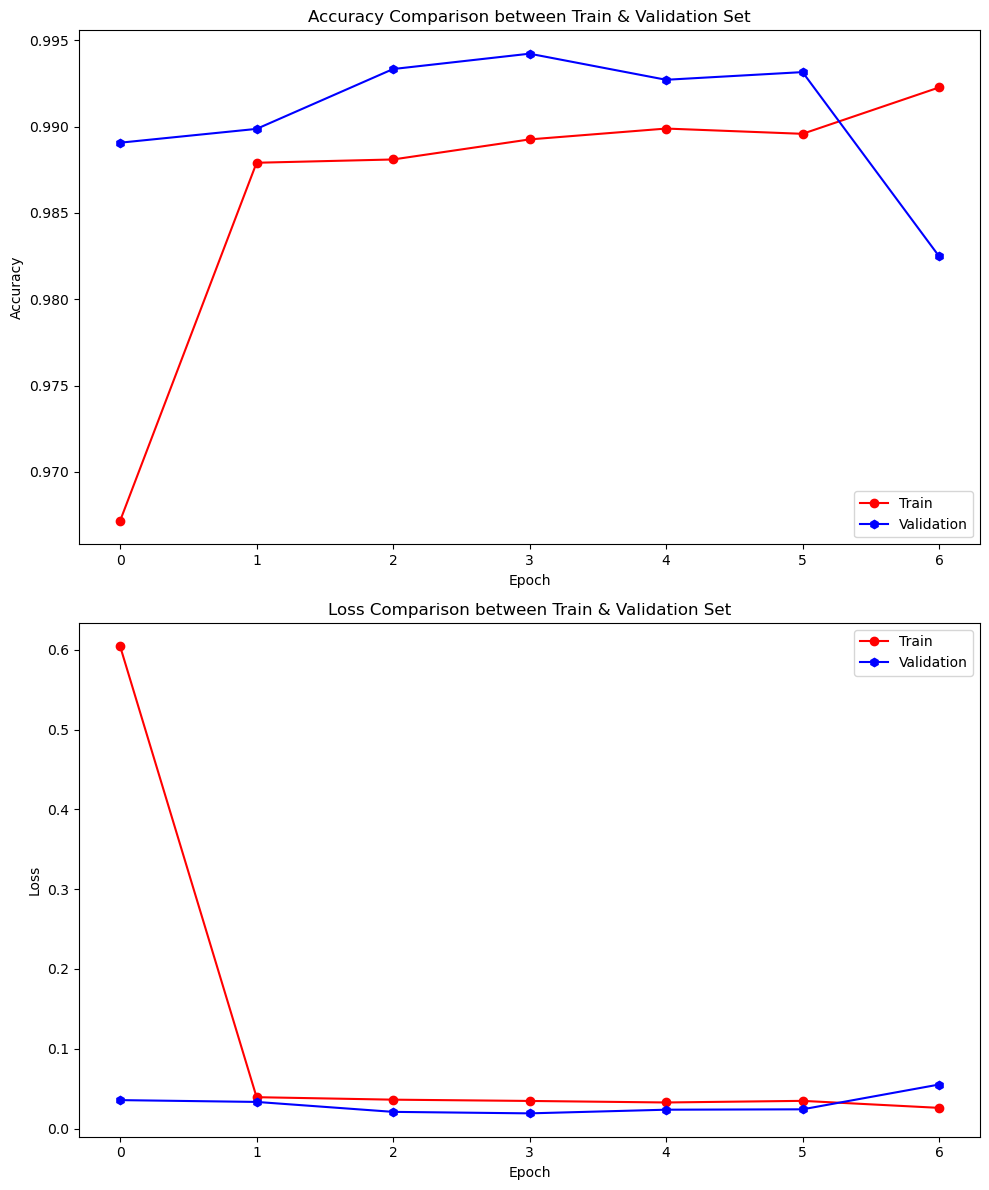

In [19]:
# plot results
plot_comparision_result(size_histories['Model 1'])

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2250
         1.0       0.96      1.00      0.98      2250
         2.0       1.00      1.00      1.00      2250
         3.0       0.99      0.95      0.97      2250
         4.0       1.00      0.97      0.98      2250

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98      0.98      0.98     11250
 




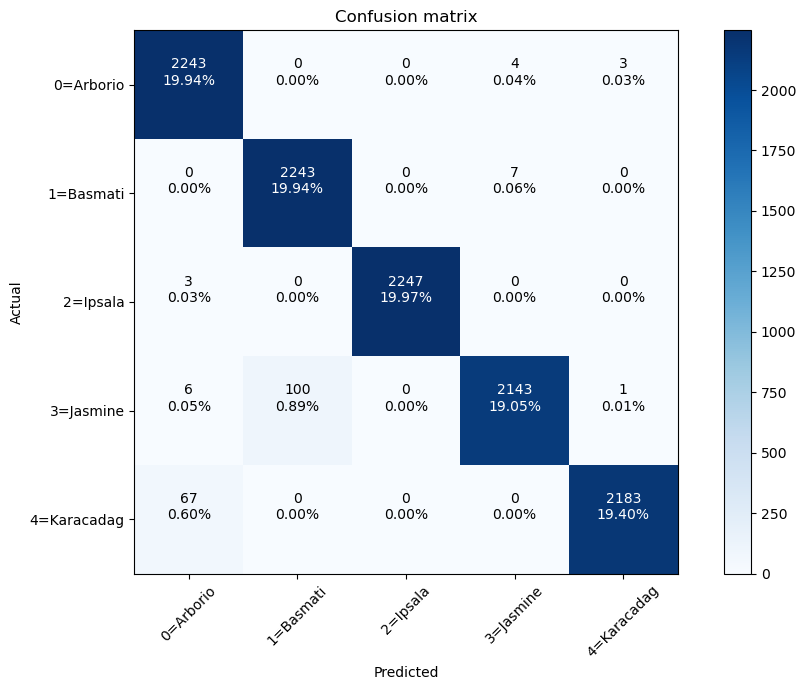

In [20]:
# plot confusion matrix 
y_true, y_pred = get_ture_and_pred_labels(val_loader, model_1)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

<a class="anchor" id="About_Data"></a>
# <p style="padding:10px;background-color:#d5eae9;margin:0;color:#c27849;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model 2</p> 

In [21]:
# Define second CNN Model: 2 conv layer | 1 pool layer | 3 full-connected layer | RelU activation
class Model2(nn.Module):
    def __init__(self, dim_output):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 59 * 59, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, dim_output)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_2 = Model2(5)

In [22]:
summary(model_2, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 246, 246]         456
├─MaxPool2d: 1-2                         [-1, 6, 123, 123]         --
├─Conv2d: 1-3                            [-1, 16, 119, 119]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 59, 59]          --
├─Linear: 1-5                            [-1, 120]                 6,683,640
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 6,697,101
Trainable params: 6,697,101
Non-trainable params: 0
Total mult-adds (M): 67.91
Input size (MB): 0.72
Forward/backward pass size (MB): 4.50
Params size (MB): 25.55
Estimated Total Size (MB): 30.76


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 246, 246]         456
├─MaxPool2d: 1-2                         [-1, 6, 123, 123]         --
├─Conv2d: 1-3                            [-1, 16, 119, 119]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 59, 59]          --
├─Linear: 1-5                            [-1, 120]                 6,683,640
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 6,697,101
Trainable params: 6,697,101
Non-trainable params: 0
Total mult-adds (M): 67.91
Input size (MB): 0.72
Forward/backward pass size (MB): 4.50
Params size (MB): 25.55
Estimated Total Size (MB): 30.76

In [24]:
# define a Loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

In [25]:
# train model_2
history_2, best_model_weights_2 = train(model_2, train_loader, val_loader,
                                        device, loss_fn, optimizer, num_epochs=25, patience=5)

  0%|                                                                                                         …

train_loss: 0.0955 | train_acc: 0.9659 | val_loss: 0.0341 | val_acc: 0.9889 



  0%|                                                                                                         …

train_loss: 0.0551 | train_acc: 0.9849 | val_loss: 0.0647 | val_acc: 0.9808 



  0%|                                                                                                         …

train_loss: 0.0369 | train_acc: 0.9882 | val_loss: 0.0245 | val_acc: 0.9936 



  0%|                                                                                                         …

train_loss: 0.0279 | train_acc: 0.9910 | val_loss: 0.0238 | val_acc: 0.9940 



  0%|                                                                                                         …

train_loss: 0.0303 | train_acc: 0.9914 | val_loss: 0.0183 | val_acc: 0.9944 



  0%|                                                                                                         …

train_loss: 0.0258 | train_acc: 0.9920 | val_loss: 0.0086 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0215 | train_acc: 0.9934 | val_loss: 0.0500 | val_acc: 0.9872 



  0%|                                                                                                         …

train_loss: 0.0223 | train_acc: 0.9935 | val_loss: 0.0299 | val_acc: 0.9900 



  0%|                                                                                                         …

train_loss: 0.0188 | train_acc: 0.9943 | val_loss: 0.0536 | val_acc: 0.9833 



  0%|                                                                                                         …

train_loss: 0.0172 | train_acc: 0.9950 | val_loss: 0.0121 | val_acc: 0.9966 



  0%|                                                                                                         …

train_loss: 0.0212 | train_acc: 0.9942 | val_loss: 0.0217 | val_acc: 0.9939 



  0%|                                                                                                         …

train_loss: 0.0185 | train_acc: 0.9949 | val_loss: 0.0138 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0137 | train_acc: 0.9958 | val_loss: 0.1427 | val_acc: 0.9756 



  0%|                                                                                                         …

train_loss: 0.0135 | train_acc: 0.9961 | val_loss: 0.0090 | val_acc: 0.9972 



  0%|                                                                                                         …

train_loss: 0.0200 | train_acc: 0.9951 | val_loss: 0.0113 | val_acc: 0.9969 



  0%|                                                                                                         …

train_loss: 0.0146 | train_acc: 0.9958 | val_loss: 0.0213 | val_acc: 0.9941 



  0%|                                                                                                         …

train_loss: 0.0118 | train_acc: 0.9968 | val_loss: 0.0110 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0149 | train_acc: 0.9954 | val_loss: 0.0115 | val_acc: 0.9963 



  0%|                                                                                                         …

train_loss: 0.0164 | train_acc: 0.9960 | val_loss: 0.0456 | val_acc: 0.9872 



  0%|                                                                                                         …

train_loss: 0.0154 | train_acc: 0.9959 | val_loss: 0.0125 | val_acc: 0.9963 



  0%|                                                                                                         …

train_loss: 0.0148 | train_acc: 0.9964 | val_loss: 0.0082 | val_acc: 0.9982 



  0%|                                                                                                         …

train_loss: 0.0198 | train_acc: 0.9957 | val_loss: 0.0123 | val_acc: 0.9968 



  0%|                                                                                                         …

train_loss: 0.0101 | train_acc: 0.9974 | val_loss: 0.0123 | val_acc: 0.9963 



  0%|                                                                                                         …

train_loss: 0.0184 | train_acc: 0.9955 | val_loss: 0.0075 | val_acc: 0.9983 



  0%|                                                                                                         …

train_loss: 0.0084 | train_acc: 0.9978 | val_loss: 0.0099 | val_acc: 0.9968 



In [26]:
# store train results
size_histories['Model 2'] = {'history':history_2, 'weights':best_model_weights_2 }

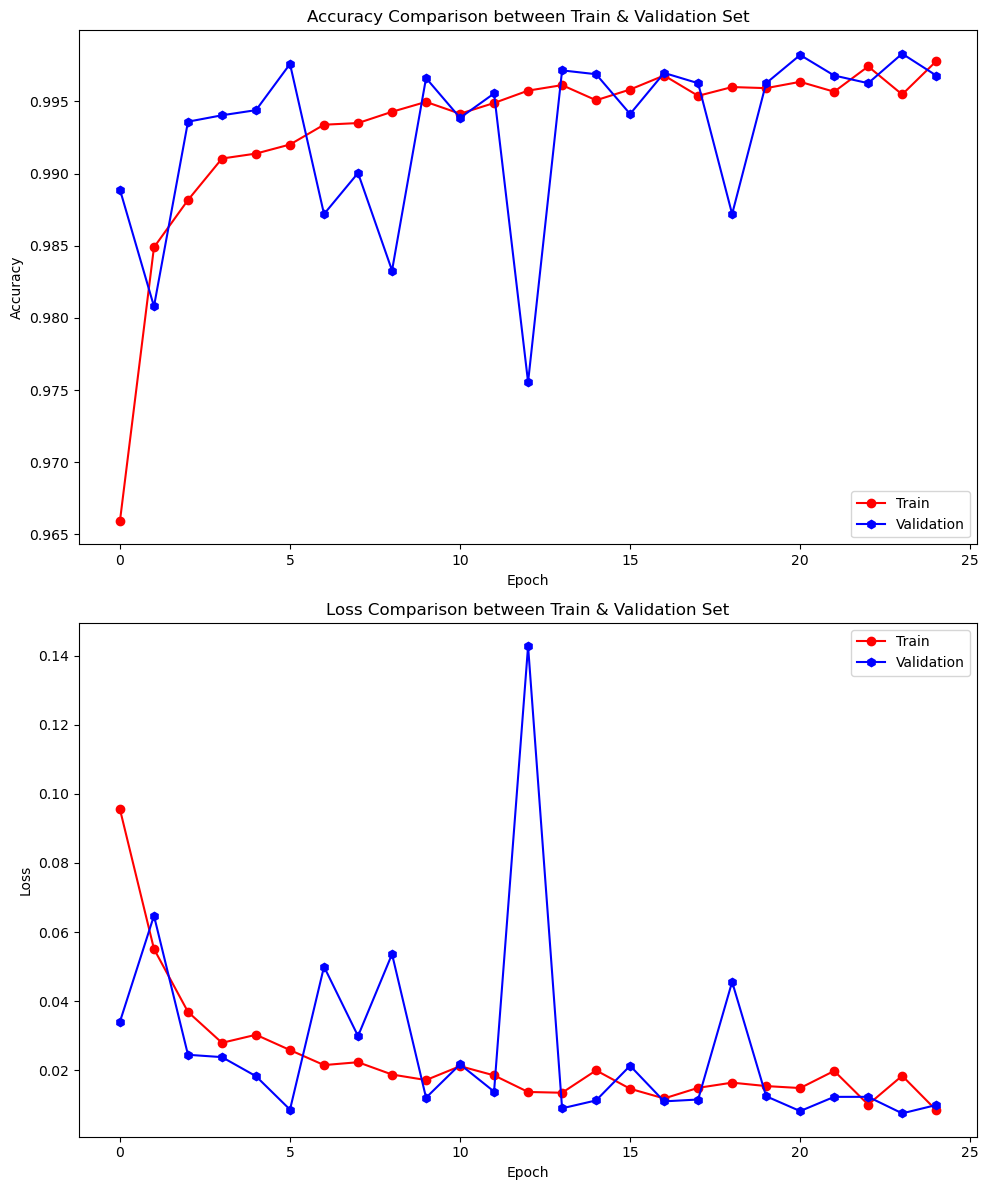

In [27]:
# plot results
plot_comparision_result(size_histories['Model 2'])

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2250
         1.0       0.99      1.00      1.00      2250
         2.0       1.00      1.00      1.00      2250
         3.0       1.00      0.99      1.00      2250
         4.0       1.00      1.00      1.00      2250

    accuracy                           1.00     11250
   macro avg       1.00      1.00      1.00     11250
weighted avg       1.00      1.00      1.00     11250
 




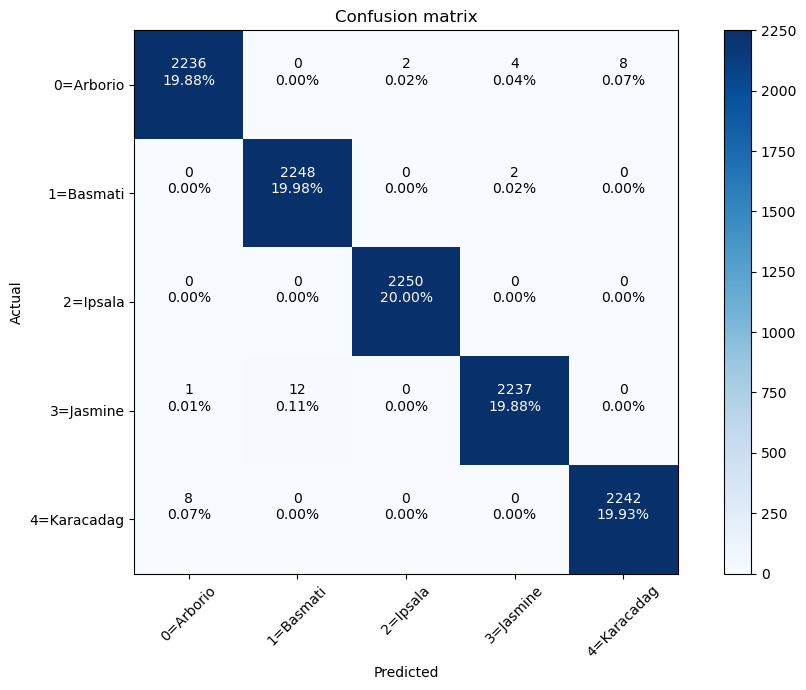

In [28]:
# plot confusion matrix 
y_true, y_pred = get_ture_and_pred_labels(val_loader, model_2)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

<a class="anchor" id="About_Data"></a>
# <p style="padding:10px;background-color:#d5eae9;margin:0;color:#c27849;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Evaluate The Final Model</p> 

In [29]:
# choose best model as final model
final_model = model_2

In [31]:
# evaluate model on test set
test_loss, test_acc = evaluate(final_model, test_loader, device, loss_fn)

print(f'Loss of the network on the {len(test_loader.dataset)} test images: {test_loss:4f}')
print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {test_acc:4f}')


Loss of the network on the 11250 test images: 0.008962
Accuracy of the network on the 11250 test images: 0.997600


In [32]:
# Store images and labels and outputs to check results of model
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model_1(images)

In [33]:
probabilities = F.softmax(outputs, dim=1)

In [34]:
def plot_image(output, true_label, img):
    """
    For plot each image
        output(Pytorch tensor): prediction for input_image
        ture_label(Pytorch tensor): true label for input_image
        img (Pytorch tensor): input_image
    """
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img_np = img.cpu().numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)

    predicted_value, predicted_label = torch.max(output, 0)
    predicted_label = predicted_label.cpu()
    true_label = true_label.cpu()

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*predicted_value,
                                class_names[true_label]),
                                color=color)

# -------------------------------------------------------------------

def plot_value_array(output, true_label):
    """
    Plot bar plot of predciton
        output(pytorch tensor): prediction array of image
        ture_label(Pytorch tensor): true label for image
    """
    
    predicted_value, predicted_label = torch.max(output, 0)
    predicted_label = predicted_label.cpu()
    true_label = true_label.cpu()
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    thisplot = plt.bar(range(5), output.cpu().detach().numpy()*100, color="#777777")
    plt.ylim([0, 100])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# -----------------------------------------------------------------------------    
    
def plot_model_result(outputs, test_labels, test_images, num_rows=10, num_cols=3):
    """
    Plot the first X test images, their predicted labels, and the true labels.
        outputs(): all predictions for all test_image
        test_labels(): all true label for all test_image
        test_images(): all test_image
    """
    
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(outputs[i], test_labels[i], test_images[i])
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(outputs[i], test_labels[i])
    plt.tight_layout()
    plt.show()

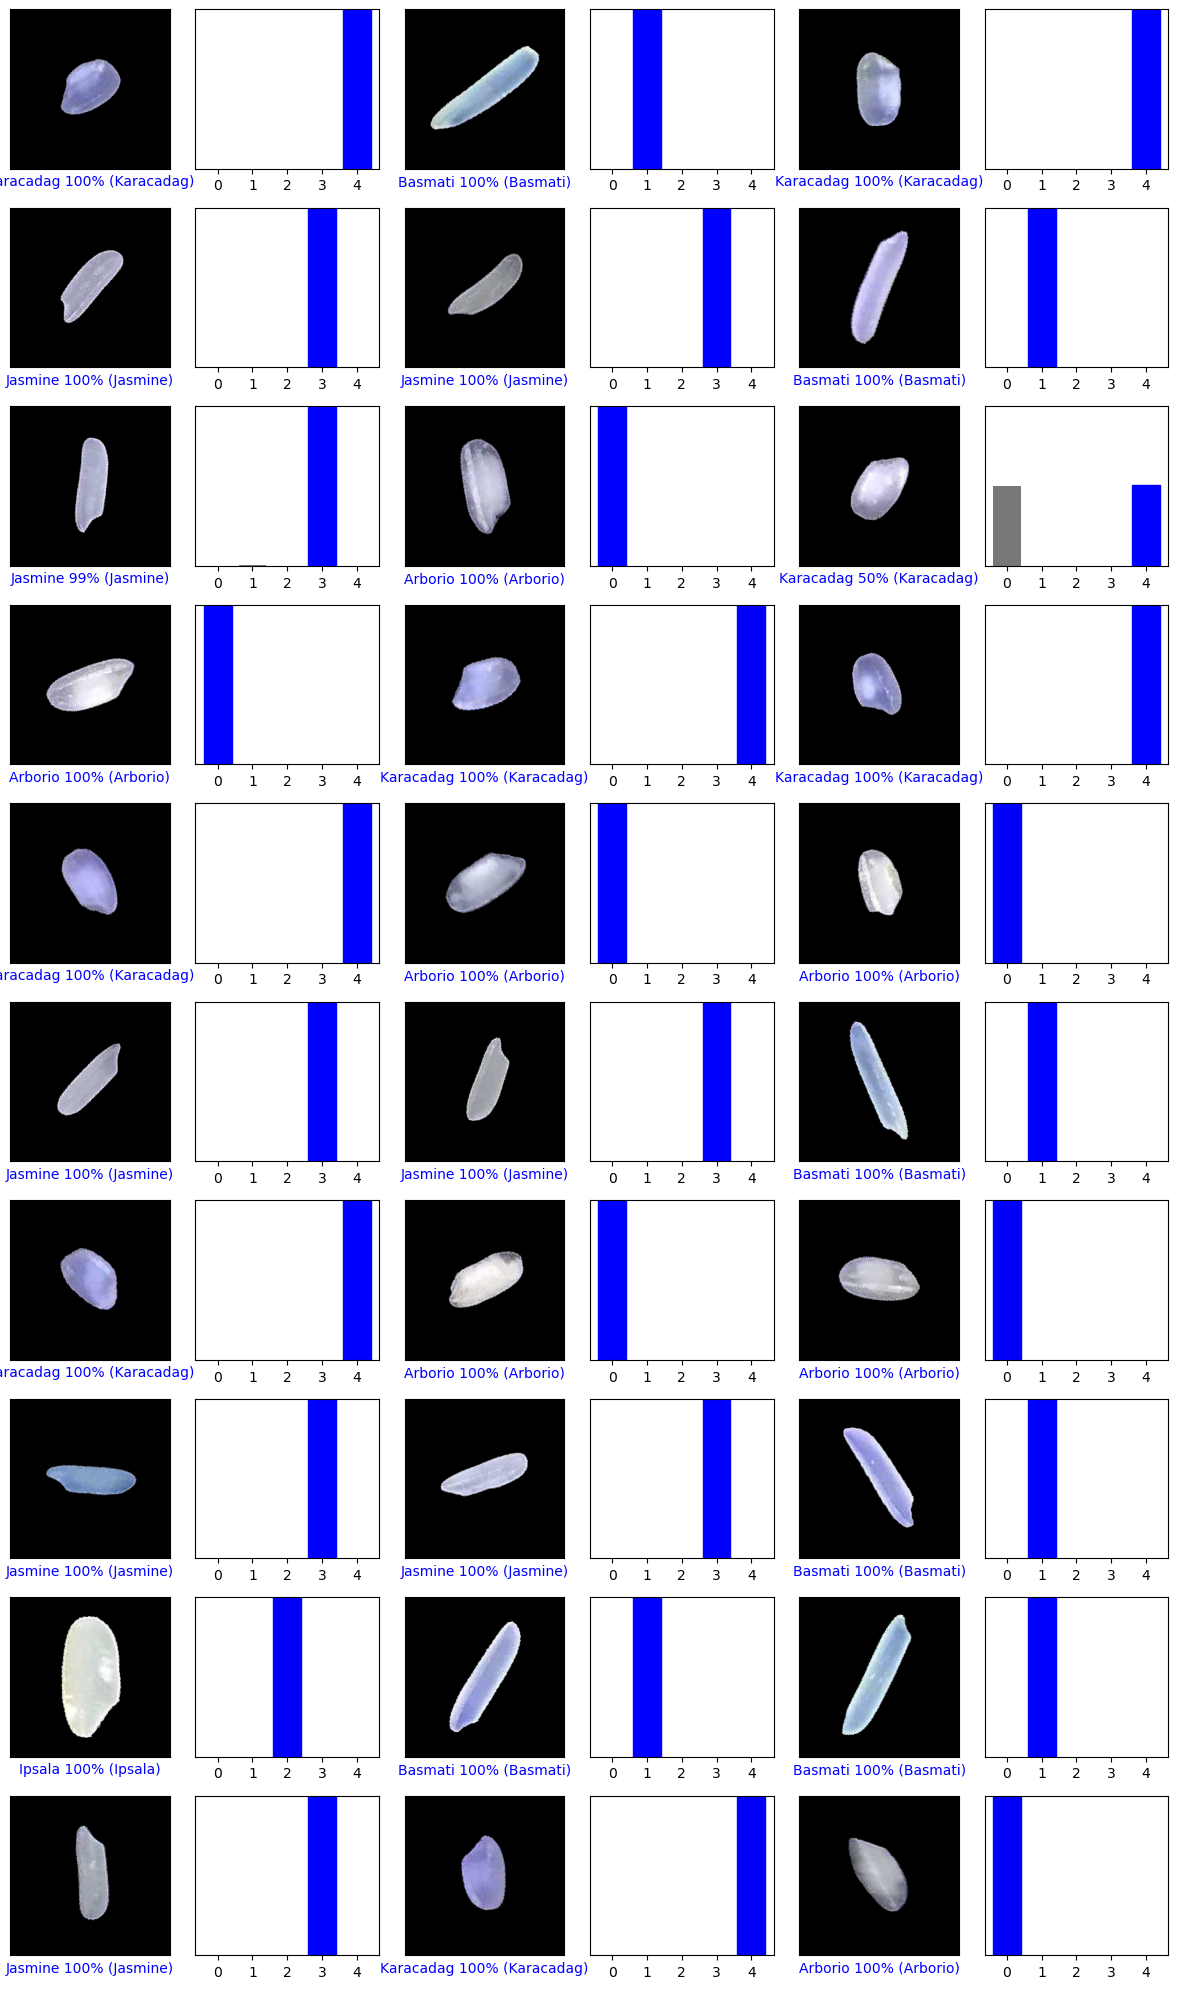

In [35]:
plot_model_result(probabilities, labels, images)